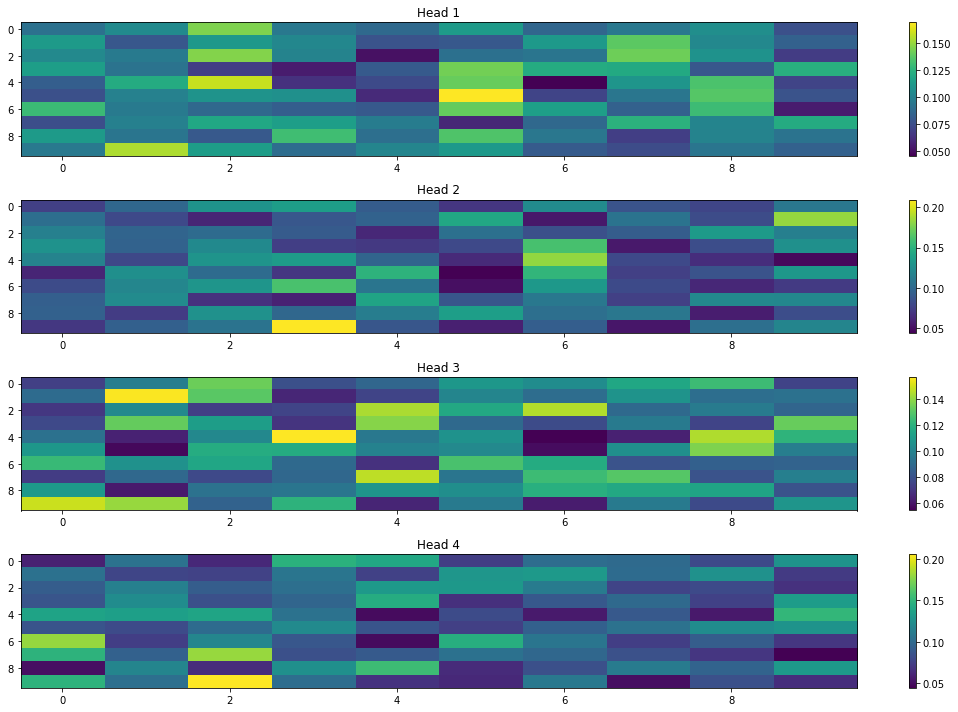

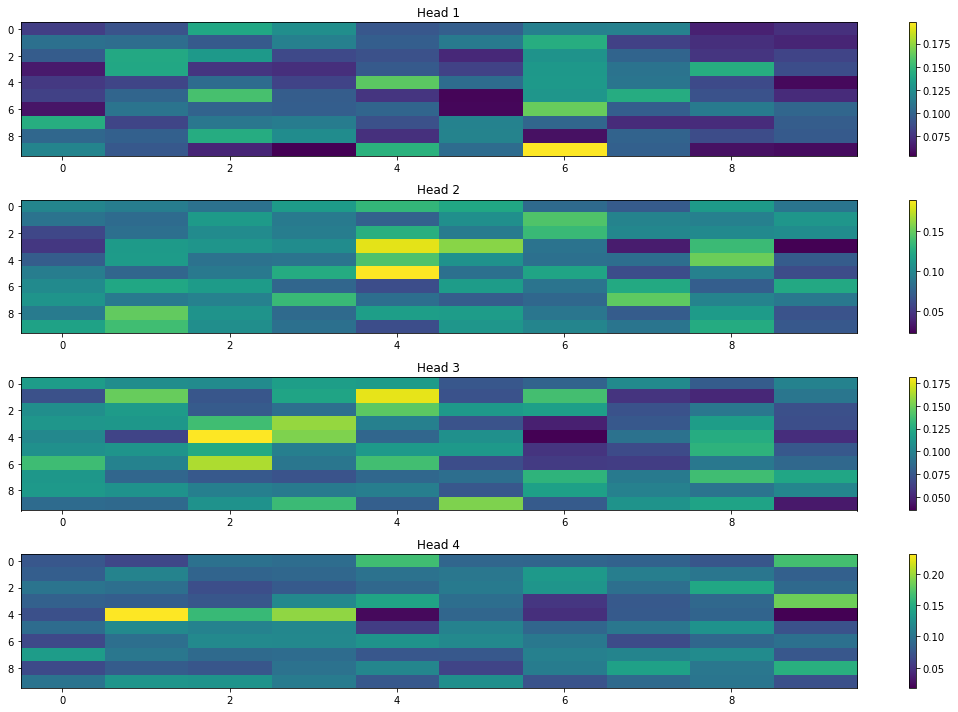

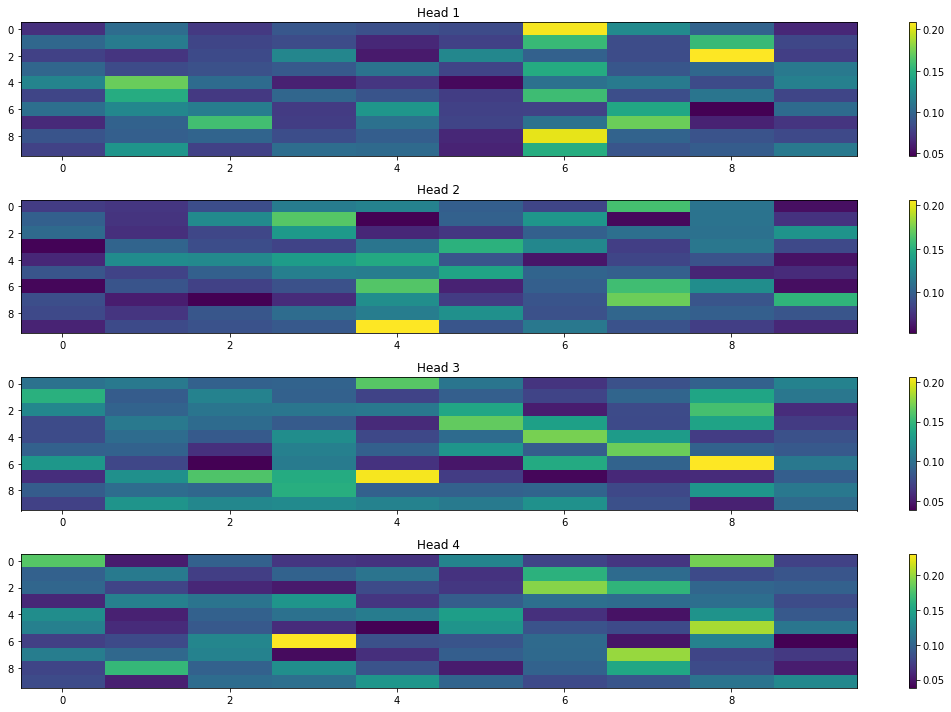

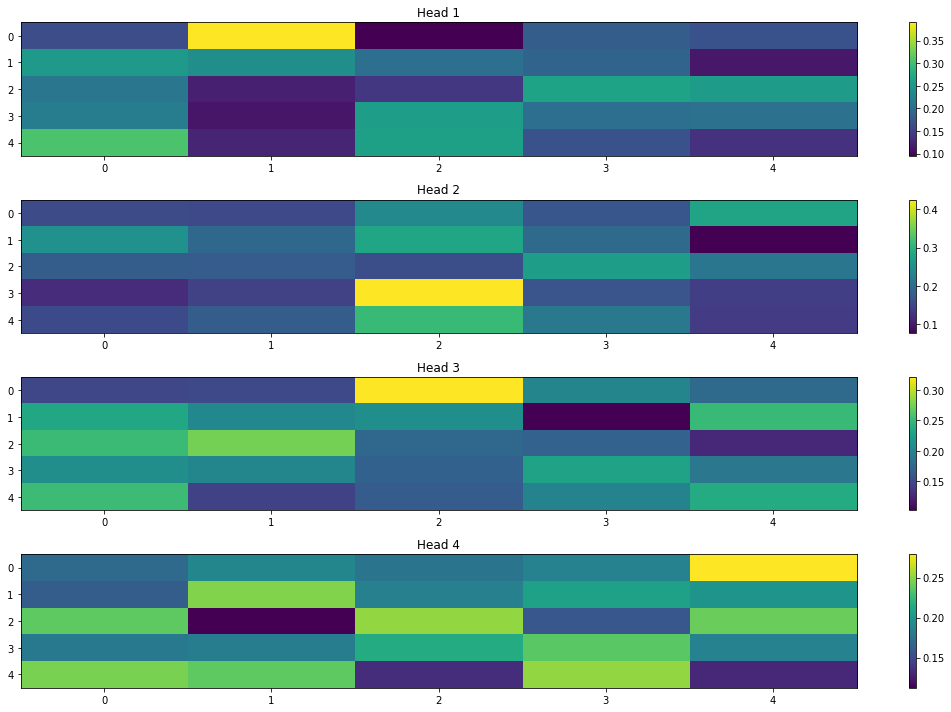

In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

class MultiHeadSelfAttention(torch.nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"

        self.linear_q = torch.nn.Linear(embed_dim, embed_dim)
        self.linear_k = torch.nn.Linear(embed_dim, embed_dim)
        self.linear_v = torch.nn.Linear(embed_dim, embed_dim)
        self.final_linear = torch.nn.Linear(embed_dim, embed_dim)
    
    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        
        Q = self.linear_q(x).view(batch_size, seq_length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = self.linear_k(x).view(batch_size, seq_length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = self.linear_v(x).view(batch_size, seq_length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        attention_weights = F.softmax(scores, dim=-1)
        attention_output = torch.matmul(attention_weights, V).transpose(1, 2).contiguous().view(batch_size, seq_length, self.embed_dim)
        
        output = self.final_linear(attention_output)
        return output, attention_weights

class MultiQueryAttention(torch.nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"

        self.linear_q1 = torch.nn.Linear(embed_dim, embed_dim)
        self.linear_q2 = torch.nn.Linear(embed_dim, embed_dim)
        self.linear_k = torch.nn.Linear(embed_dim, embed_dim)
        self.linear_v = torch.nn.Linear(embed_dim, embed_dim)
        self.final_linear = torch.nn.Linear(embed_dim * 2, embed_dim)

    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        
        Q1 = self.linear_q1(x).view(batch_size, seq_length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        Q2 = self.linear_q2(x).view(batch_size, seq_length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        K = self.linear_k(x).view(batch_size, seq_length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        V = self.linear_v(x).view(batch_size, seq_length, self.num_heads, self.head_dim).permute(0, 2, 1, 3)


        scores1 = torch.matmul(Q1, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        attention_weights1 = F.softmax(scores1, dim=-1)
        attention_output1 = torch.matmul(attention_weights1, V).transpose(1, 2).contiguous().view(batch_size, seq_length, self.embed_dim)
        
        scores2 = torch.matmul(Q2, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        attention_weights2 = F.softmax(scores2, dim=-1)
        attention_output2 = torch.matmul(attention_weights2, V).transpose(1, 2).contiguous().view(batch_size, seq_length, self.embed_dim)

        concatenated_output = torch.cat([attention_output1, attention_output2], dim=-1)
        output = self.final_linear(concatenated_output)
        
        return output, attention_weights1, attention_weights2 
    
class GroupQueryAttention(torch.nn.Module):
    def __init__(self, embed_dim, num_heads, num_groups):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_groups = num_groups
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"

        self.linear_q = torch.nn.Linear(embed_dim, embed_dim)
        self.linear_k = torch.nn.Linear(embed_dim, embed_dim)
        self.linear_v = torch.nn.Linear(embed_dim, embed_dim)
        self.final_linear = torch.nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size, seq_length, _ = x.size()

        group_size = seq_length // self.num_groups
        x_grouped = x.view(batch_size, self.num_groups, group_size, self.embed_dim)
        
        outputs = []
        for i in range(self.num_groups):
            x_i = x_grouped[:, i, :, :]
            Q = self.linear_q(x_i).view(batch_size, group_size, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
            K = self.linear_k(x_i).view(batch_size, group_size, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
            V = self.linear_v(x_i).view(batch_size, group_size, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

            scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
            attention_weights = F.softmax(scores, dim=-1)
            attention_output = torch.matmul(attention_weights, V).transpose(1, 2).contiguous().view(batch_size, group_size, self.embed_dim)
            outputs.append(attention_output)

        output_concat = torch.cat(outputs, dim=1)
        output = self.final_linear(output_concat)
        
        return output, attention_weights
    
def visualize_attention(attention_weights, num_heads):

    batch_size = attention_weights.size(0)
    for b in range(batch_size):
        plt.figure(figsize=(15, 10))
        for head in range(num_heads):
            plt.subplot(num_heads, 1, head + 1)
            plt.imshow(attention_weights[b, head].detach(), cmap='viridis', aspect='auto')
            plt.colorbar()
            plt.title(f'Head {head+1}')
        plt.tight_layout()
        plt.show()

dim = 64
num_heads = 4
num_groups = 2
x = torch.randn(1, 10, dim)

msa = MultiHeadSelfAttention(embed_dim=dim, num_heads=num_heads)
output_msa, weights_msa = msa(x)
visualize_attention(weights_msa, num_heads=num_heads)

mqa = MultiQueryAttention(embed_dim=dim, num_heads=num_heads)
output_mqa, weights_mqa1, weights_mqa2 = mqa(x)
visualize_attention(weights_mqa1, num_heads=num_heads)
visualize_attention(weights_mqa2, num_heads=num_heads)

gqa = GroupQueryAttention(embed_dim=dim, num_heads=num_heads, num_groups=num_groups)
output_gqa, weights_gqa = gqa(x)
visualize_attention(weights_gqa, num_heads=num_heads)